<a href="https://colab.research.google.com/github/nicoyogis/TUBES-TKC/blob/main/final/code_fix_TKC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import os  # Create directories, list files
import zipfile
import shutil
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mping
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop,SGD
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import time


In [ ]:
Effusion="/content/drive/MyDrive/projek2/dataset/Effusion/"
Normal="/content/drive/MyDrive/projek2/dataset/Normal/"
Tube="/content/drive/MyDrive/projek2/dataset/Tube/"
data_uji="/content/drive/MyDrive/projek2/data_uji/"
data_latih="/content/drive/MyDrive/projek2/data_latih/"

In [ ]:
Target = "/content/drive/MyDrive/projek2/dataset_split_biasa"
Source = "/content/drive/MyDrive/projek2/dataset"

In [ ]:
# !pip install split_folders
# import splitfolders

In [ ]:
# splitfolders.ratio(input=Source, output=Target, seed=1337, ratio=(0.7, 0.3))

In [ ]:
Train = "/content/drive/MyDrive/projek2/dataset_split_biasa/train"
Val = "/content/drive/MyDrive/projek2/dataset_split_biasa/val"

Train_roi = "/content/drive/MyDrive/projek2/dataset_split/train"
Val_roi = "/content/drive/MyDrive/projek2/dataset_split/val"

# Resize

In [ ]:
import cv2
import numpy as np

# Normal
for r, d, f in os.walk(data_uji):
    for file in f:
        if ".jpg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (224,224))
            basename = os.path.basename(file) 
            name = os.path.splitext(basename)[0] 
            cv2.imwrite('/content/drive/MyDrive/projek2/data_uji224/' + name + '-resized.jpg', image)  

In [ ]:
import cv2
import numpy as np

# Tube
for r, d, f in os.walk(data_latih):
    for file in f:
        if ".jpg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (224,224))
            basename = os.path.basename(file) 
            name = os.path.splitext(basename)[0] 
            cv2.imwrite('/content/drive/MyDrive/projek2/data_latih224/' + name + '-resized.jpg', image)  

# LOAD MANUAL

In [ ]:
import cv2
import numpy as np

# Gather data train
train_data = []

train_label = []
for r, d, f in os.walk(Train_roi):
    for file in f:
        if ".jpg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (224,224))
            train_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            train_label.append(label)

train_data = np.array(train_data)
train_label = np.array(train_label)

In [ ]:
val_data = []
val_label = []
for r, d, f in os.walk(Val_roi):
    for file in f:
        if ".jpg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (224,224))
            val_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            val_label.append(label)

val_data = np.array(val_data)
val_label = np.array(val_label)

In [ ]:
# Tampilkan shape dari data train dan data validation
print("Train Data = ", train_data.shape)
print("Train Label = ", train_label.shape)
print("Validation Data = ", val_data.shape)
print("Validation Label = ", val_label.shape)

Train Data =  (317, 224, 224, 3)
Train Label =  (317,)
Validation Data =  (137, 224, 224, 3)
Validation Label =  (137,)


In [ ]:
x_train = train_data.astype('float32') / 255.0
x_val = val_data.astype('float32') / 255.0

In [ ]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
y_train = lb.fit_transform(train_label)
y_val = lb.fit_transform(val_label)

In [ ]:
y_train = to_categorical(y_train, 3)
y_val = to_categorical(y_val, 3)

In [ ]:
train_gen.fit(x_train)

In [ ]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(317, 224, 224, 3)
(137, 224, 224, 3)
(317, 3)
(137, 3)


# ImageDataGenerator

In [ ]:
# define generator
from keras.preprocessing.image import ImageDataGenerator
train_gen = ImageDataGenerator(
    
  #  shear_range = 0.2,
  #  zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
  #  rotation_range=20,
  #  width_shift_range=0.2,
  #  height_shift_range=0.2,
        # featurewise_center=True,
    # featurewise_std_normalization=True,
    rotation_range=20, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2, 
    # horizontal_flip=True, 
    fill_mode="nearest"
    
)

val_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_generator = train_gen.flow_from_directory(
    Train_roi,
    target_size=(250, 250),
    class_mode='categorical',
    color_mode="rgb",
    shuffle=True,
    batch_size=317
)

validation_generator = val_gen.flow_from_directory(
    Val_roi,
    target_size=(250,250),
    class_mode='categorical',
    color_mode="rgb",
    shuffle=False,
    batch_size=16
)

Found 317 images belonging to 3 classes.
Found 137 images belonging to 3 classes.


# Model Pretrain


In [ ]:
#from keras.applications.nasnet import NASNetLarge
#from keras.applications.inception_v4 import InceptionV4
#from keras.applications import inception_v4
from keras.applications.vgg16 import VGG16 
from keras.models import Model
from keras import backend as K
from keras.layers import Dense,Flatten
import tensorflow as tf

In [ ]:
base_model1=tf.keras.applications.vgg16.VGG16(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
x = base_model1.output
x = GlobalAveragePooling2D()
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)
model1 = Model(inputs=base_model1.input, outputs=predictions)

In [ ]:
# for layer in base_model1.layers:
#     layer.trainable = True

In [ ]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model1.compile(Adam(learning_rate=0.0002), loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
history = model1.fit(train_gen.flow(x_train, y_train, batch_size=16),validation_data=(x_val,y_val),epochs=100)

Epoch 1/100
20/20 [==============================] - 667s 33s/step - loss: 1.4301 - accuracy: 0.3849 - val_loss: 1.0741 - val_accuracy: 0.3504
Epoch 2/100
20/20 [==============================] - 665s 33s/step - loss: 1.0861 - accuracy: 0.3975 - val_loss: 1.0629 - val_accuracy: 0.4672
Epoch 3/100
20/20 [==============================] - 666s 33s/step - loss: 1.0714 - accuracy: 0.4038 - val_loss: 1.0598 - val_accuracy: 0.4599
Epoch 4/100
20/20 [==============================] - 666s 33s/step - loss: 1.0652 - accuracy: 0.4196 - val_loss: 1.0824 - val_accuracy: 0.3942
Epoch 5/100
20/20 [==============================] - 666s 33s/step - loss: 1.0909 - accuracy: 0.3533 - val_loss: 1.0905 - val_accuracy: 0.3942
Epoch 6/100
20/20 [==============================] - 664s 33s/step - loss: 1.0863 - accuracy: 0.3943 - val_loss: 1.0834 - val_accuracy: 0.3942
Epoch 7/100
20/20 [==============================] - 665s 33s/step - loss: 1.0805 - accuracy: 0.3817 - val_loss: 1.0780 - val_accuracy: 0.3942

In [ ]:
#model 1
y_val_hat1 = model1.predict(x_val, batch_size=16)
y_val_hat1 = np.argmax(y_val_hat1, axis=1)
y_val = np.argmax(y_val, axis=1)

clas_r = classification_report(y_val, y_val_hat1)
# print classification report
print('Classification report on test data')
print(clas_r)

Classification report on test data
              precision    recall  f1-score   support

           0       0.84      0.91      0.88        54
           1       0.92      0.91      0.92        54
           2       0.92      0.83      0.87        29

    accuracy                           0.89       137
   macro avg       0.90      0.88      0.89       137
weighted avg       0.89      0.89      0.89       137



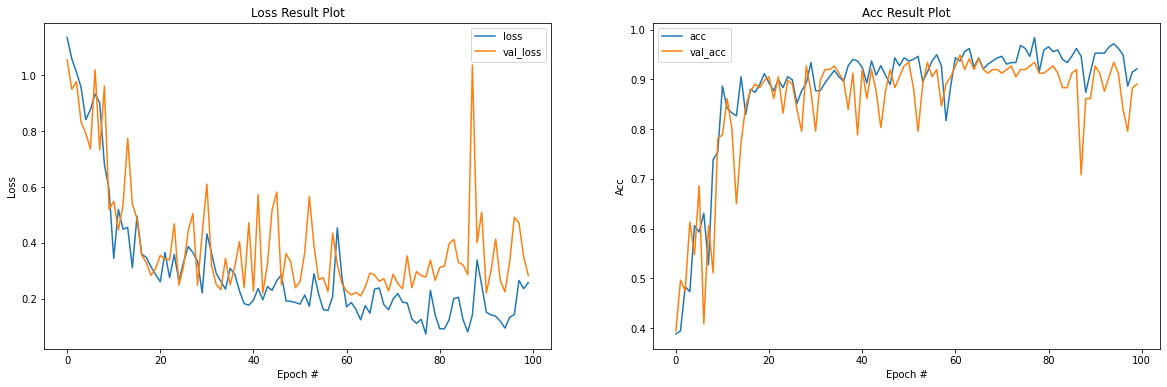

In [ ]:
#plot model 1
fig, (plt1, plt2) = plt.subplots(1,2, figsize=(20,6)) #buat bikin subplot

plt1.figsize=(10,8)
plt1.plot(np.arange(0, 100), history.history["loss"], label="loss")
plt1.plot(np.arange(0, 100), history.history["val_loss"], label="val_loss")
plt1.set_title("Loss Result Plot")
plt1.set_xlabel("Epoch #")
plt1.set_ylabel("Loss")
plt1.legend()

plt2.figsize=(10,8)
plt2.plot(np.arange(0, 100), history.history["accuracy"], label="acc")
plt2.plot(np.arange(0, 100), history.history["val_accuracy"], label="val_acc")
plt2.set_title("Acc Result Plot")
plt2.set_xlabel("Epoch #")
plt2.set_ylabel("Acc")
plt2.legend()

Text(0.5, 0.5, 'Predicted labels')

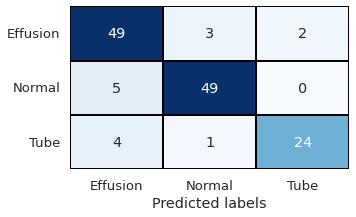

In [ ]:
# calculate confusion matrix & classification report model 1
import seaborn as sns
conf_m = confusion_matrix(y_val, y_val_hat1)

# plot confusion matrix as heatmap
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_m, annot=True,xticklabels=['Effusion', 'Normal','Tube'], yticklabels=['Effusion', 'Normal','Tube'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')

In [ ]:
from keras.models import model_from_json
import json

target_dir = "/content/drive/MyDrive/projek2/model_tkc"

# simpan history model kedua
history_dict = history.history
json.dump(history_dict, open(target_dir + '/history_model_vgg16_89.json', 'w'))

# simpan model kedua dan weight-nya
model1.save(target_dir + '/model_vgg16_89.h5')
model1.save_weights(target_dir + '/model_weights_model_vgg16_89.h5')

# Feature Extractor

In [ ]:
from numpy import loadtxt
from keras.models import load_model

In [ ]:
model_utuh = load_model('/content/drive/MyDrive/projek2/model_tkc/model_vgg16_89.h5')

In [ ]:
model_utuh.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model_fe=Model(inputs=model_utuh.input, outputs=model_utuh.get_layer('global_average_pooling2d').output)

In [ ]:
model_fe.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
from numpy import loadtxt
from keras.models import load_model
from tensorflow.keras import preprocessing
from tensorflow.keras.applications.densenet import preprocess_input

class FeatureExtractor:
    def __init__(self, model):
        self.model = model
    
    def extract(self, img):
        img = img.convert('RGB')
        
        x = preprocessing.image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        
        feature = self.model.predict(x)[0]
        
        return feature / np.linalg.norm(feature)

# modelCBIR = FeatureExtractor(model_fe)


In [ ]:
from pathlib import Path
from PIL import Image

In [ ]:
base_dir = '/content/drive/MyDrive/split/data_latih224/'
feature_dir = '/content/drive/MyDrive/features/'

img_paths = list()
features = list() 

for img_path in sorted(Path(base_dir).glob("*.jpeg")):
     img_paths.append(img_path)
     feature = vgg16.extract(img=Image.open(img_path))
     features.append(feature)

features = np.array(features)
np.save(feature_dir + '/features_vgg16_baru.npy', features)



In [ ]:
features_vgg16_baru = np.load(feature_dir + '/features_vgg16_baru.npy')
# features_vgg163 = np.load(feature_dir + '/features_vgg16_3.npy')

In [ ]:
from pathlib import Path
test_dir = '/content/drive/MyDrive/split/data_uji224/'

test_img_paths = list()
for img_path in sorted(Path(test_dir).glob("*.jpeg")):
    test_img_paths.append(img_path)

# shuffle(test_img_paths)



In [ ]:
test_img_paths[3]

PosixPath('/content/drive/MyDrive/split/data_uji224/0-110-test.jpeg')

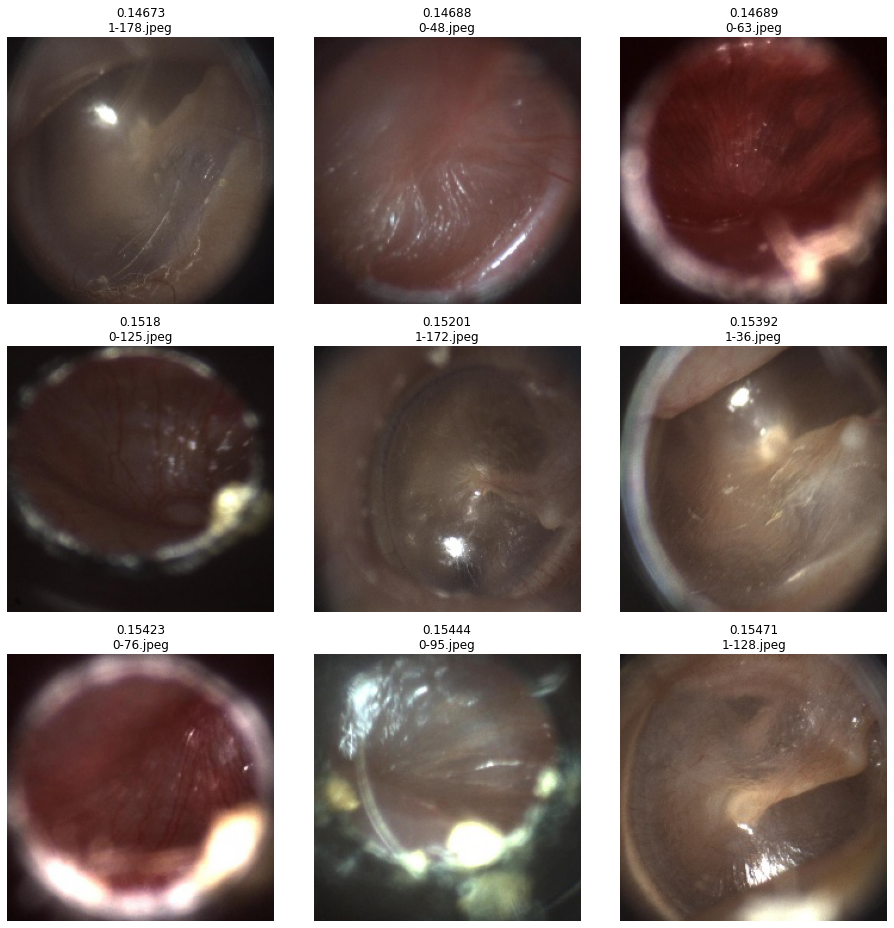

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

random_test_img = test_img_paths[2]

query_image = random_test_img
img = Image.open(query_image)
query_image_name = os.path.basename(query_image)

query = vgg16.extract(img)

dists = np.linalg.norm(features_vgg16_baru - query, axis=1)

# Extract 25 images that have lowest distance
ids = np.argsort(dists)[:25]
scores = [(dists[id], img_paths[id]) for id in ids]

# Visualize the result
axes = list()
fig = plt.figure(figsize=(13, 13))

is_miss = 0

for a in range(3 * 3):
    axes.append(fig.add_subplot(3, 3, a+1))

    score = scores[a]

    nama_citra = os.path.basename(score[1])

    subplot_title = str(round(score[0], 5)) + f"\n{nama_citra}"

    # if query_image_name[0] != nama_citra[0]:
    #     subplot_title = 'MISS\n' + subplot_title
    #     is_miss += 1
    # subplot_title = subplot_title if query_image_name[0] == nama_citra[0] else 'MISS\n' + subplot_title
    axes[-1].set_title(subplot_title)  

    plt.axis('off')
    plt.imshow(Image.open(score[1]))

fig.tight_layout()
# fig_title = f"Query: {query_image_name}\nMiss: {is_miss}"
# fig.suptitle(fig_title, y=1.05, fontsize=16)
plt.show()

# load model VGG16 tanpa fully connected layer

In [ ]:
from tensorflow.keras import preprocessing
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, model_from_json
from keras.models import load_model
from random import choice, shuffle
from pathlib import Path
from PIL import Image
import numpy as np
import os

In [ ]:
base_model = VGG16()
model_vgg16 = Model(inputs=base_model.input,
               outputs=base_model.get_layer('fc1').output)

model_vgg16.save('/content/drive/MyDrive/model_tkc/cxr_vgg16.h5')

553476096/553467096 [==============================] - 3s 0us/step


In [ ]:
vgg16 = FeatureExtractor(load_model('/content/drive/MyDrive/model_tkc/cxr_vgg16.h5', compile=False))

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     